In [5]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'
KAGGLE_FOLDER = DATA_FOLDER + 'kaggle/'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'
KAGGLE_FILE = KAGGLE_FOLDER + 'movies_metadata.csv'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import datetime

from pandas_profiling import ProfileReport
%matplotlib inline

from data_wrangling_tools import *

# Neural Networks
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split


from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [7]:
# load movies
movies = generate_clean_df_with_kaggle(CHARACTERS_FILE, ETHNICITY_FILE, MOVIES_FILE, KAGGLE_FILE)

In [40]:
def drop_nulls(df):
    return df.dropna(subset=['release_date', 'box_office_revenue', 'runtime', 'char_name', 'a_name', 'a_gender', 'a_ethnicity', 'a_dob', 'a_age_at_release', 'a_height'])

In [41]:
print(f'Movies: {movies.shape[0]}')
movies_dropna = drop_nulls(movies)
print(f'Movies With dropped nulls: {movies_dropna.shape[0]}')
movies_dropna

Movies: 451050
Movies With dropped nulls: 22613


,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,genres,languages,countries,char_name,a_name,a_gender,a_ethnicity,a_dob,a_age_at_release,a_height
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Desolation Williams,Ice Cube,M,Black,1969-06-15,32.0,1.727
5,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Commander Helena Braddock,Pam Grier,F,Black,1949-05-26,52.0,1.727
76,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"[Thriller, Science Fiction, Future noir, Indie...",[English Language],[United States of America],Sandii,Asia Argento,F,White,1975-09-20,24.0,1.680
77,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"[Thriller, Science Fiction, Future noir, Indie...",[English Language],[United States of America],Fox,Christopher Walken,M,White,1943-03-31,56.0,1.830
100,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"[Crime Fiction, Drama, Coming of age]",[English Language],[United States of America],Yvette,Taraji P. Henson,F,Black,1970-09-11,30.0,1.650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450855,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"[Thriller, Science Fiction, Action/Adventure, ...",[English Language],"[France, United States of America]",Max Denoff,Russell Peters,M,Native / Indigenous people,1970-09-29,40.0,1.800
450930,6456053,/m/0g605h,The Yellow Rolls-Royce,1964-12-31,5400000.0,122.0,"[Drama, Comedy of manners, Comedy-drama, Comedy]",[English Language],[United Kingdom],Gerda Millett,Ingrid Bergman,F,White,1915-08-29,49.0,1.750
450932,6456053,/m/0g605h,The Yellow Rolls-Royce,1964-12-31,5400000.0,122.0,"[Drama, Comedy of manners, Comedy-drama, Comedy]",[English Language],[United Kingdom],Lady Eloise Frinton,Jeanne Moreau,F,White,1928-01-23,36.0,1.600
450933,6456053,/m/0g605h,The Yellow Rolls-Royce,1964-12-31,5400000.0,122.0,"[Drama, Comedy of manners, Comedy-drama, Comedy]",[English Language],[United Kingdom],Paolo Maltese,George C. Scott,M,White,1927-10-18,37.0,1.850


In [48]:
# top 100 actors sorted by box office revenue
top_actors = movies_dropna.groupby('a_name')['box_office_revenue'].sum().sort_values(ascending=False).head(100).index
top_actors[0:10]

Index(['Warwick Davis', 'Samuel L. Jackson', 'Gary Oldman', 'Alan Rickman',
       'Robbie Coltrane', 'Tom Hanks', 'Maggie Smith', 'Helena Bonham Carter',
       'Eddie Murphy', 'Timothy Spall'],
      dtype='object', name='a_name')

In [49]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

In [50]:
countries = to_1D(movies_dropna['countries']).unique()
genres = to_1D(movies_dropna['genres']).unique()
languages = to_1D(movies_dropna['languages']).unique()
actor_genders = movies_dropna['a_gender'].unique()
actor_ethnicities = movies_dropna['a_ethnicity'].unique()

print(f'Countries: {len(countries)}')
print(f'Genres: {len(genres)}')
print(f'Languages: {len(languages)}')
print(f'Top Actors: {len(top_actors)}')
print(f'Actor genders: {len(actor_genders)}')
print(f'Actor ethnicities: {len(actor_ethnicities)}')

Countries: 86
Genres: 281
Languages: 132
Top Actors: 100
Actor genders: 2
Actor ethnicities: 5


In [70]:
def augment_movies(movies, countries, genres, languages, onehot=True):
    movies_augmented = movies.copy()

    if onehot:
        for country in countries:
            movies_augmented[f'country:{country}'] = movies_augmented['countries'].apply(lambda x: 1 if country in x else 0)

        for genre in genres:
            movies_augmented[f'genre:{genre}'] = movies_augmented['genres'].apply(lambda x: 1 if genre in x else 0)

        # for language in languages:
        #     movies_augmented[f'language:{language}'] = movies_augmented['languages'].apply(lambda x: 1 if language in x else 0)

        for actor in top_actors:
            movies_augmented[f'actor:{actor}'] = movies_augmented['a_name'].apply(lambda x: 1 if actor in x else 0)

        for gender in actor_genders:
            movies_augmented[f'a_gender:{gender}'] = movies_augmented['a_gender'].apply(lambda x: 1 if actor in x else 0)

        for ethnicity in actor_ethnicities:
            movies_augmented[f'a_ethnicity:{ethnicity}'] = movies_augmented['a_ethnicity'].apply(lambda x: 1 if actor in x else 0)

    movies_augmented['release_date'] = movies_augmented['release_date'].apply(lambda x: x.toordinal() if not pd.isna(x) else 0)
    movies_augmented['runtime'] = movies_augmented['runtime'].apply(lambda x: x if not pd.isna(x) else 0)

    movies_augmented = movies_augmented.drop(['wiki_movie_id', 'freebase_movie_id', 'movie_name', 'countries', 'genres', 'languages','char_name', 'a_gender', 'a_ethnicity', 'a_name', 'a_dob'], axis=1)

    return movies_augmented

dataset1 = augment_movies(movies_dropna, countries, genres, languages, onehot=True)
dataset1.describe()

,release_date,box_office_revenue,runtime,a_age_at_release,a_height,country:United States of America,country:South Korea,country:China,country:United Kingdom,country:France,...,actor:John Goodman,actor:Keanu Reeves,actor:Jada Pinkett Smith,a_gender:M,a_gender:F,a_ethnicity:Black,a_ethnicity:White,a_ethnicity:Asian,a_ethnicity:Latino,a_ethnicity:Native / Indigenous people
count,22613.000000,2.261300e+04,22613.000000,22613.000000,22613.000000,22613.000000,22613.000000,22613.000000,22613.000000,22613.000000,...,22613.000000,22613.000000,22613.000000,22613.0,22613.0,22613.0,22613.0,22613.0,22613.0,22613.0
mean,729770.646708,1.023190e+08,110.543537,37.952196,1.754973,0.919162,0.004378,0.004113,0.159422,0.057533,...,0.002476,0.001548,0.000929,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,4462.111821,1.866464e+08,25.661926,13.710847,0.103864,0.272593,0.066023,0.064000,0.366077,0.232864,...,0.049703,0.039312,0.030461,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,703450.000000,1.000000e+00,10.000000,-34.000000,0.813000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,728285.000000,8.141292e+06,95.000000,28.000000,1.680000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,730883.000000,3.346397e+07,106.000000,36.000000,1.753000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,732836.000000,1.094370e+08,120.000000,46.000000,1.830000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,735138.000000,2.782275e+09,1003.000000,94.000000,2.200000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


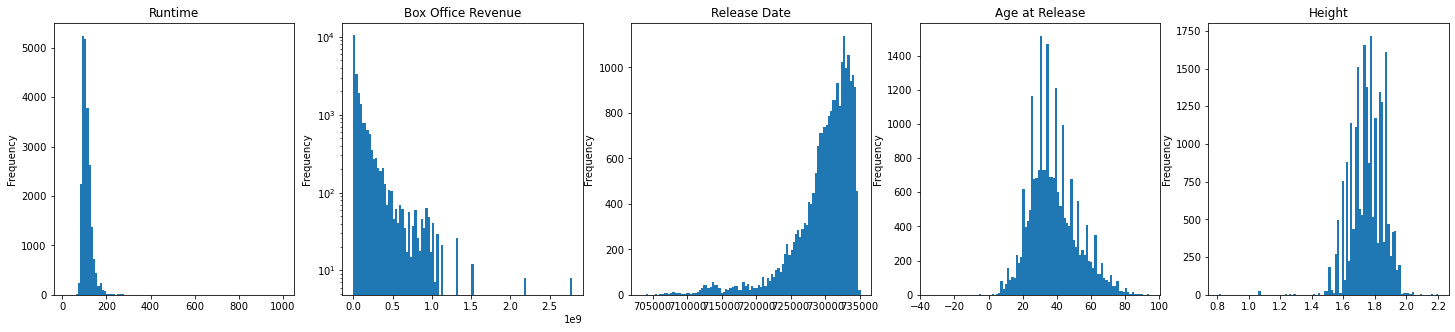

In [73]:
def plot_dataset(dataset):
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))

    dataset["runtime"].plot.hist(bins=100, ax=axs[0])
    dataset["box_office_revenue"].plot.hist(bins=100, log=True, ax=axs[1])
    dataset["release_date"].plot.hist(bins=100, ax=axs[2])
    dataset["a_age_at_release"].plot.hist(bins=100, ax=axs[3])
    dataset["a_height"].plot.hist(bins=100, ax=axs[4])

    axs[0].set_title("Runtime")
    axs[1].set_title("Box Office Revenue")
    axs[2].set_title("Release Date")
    axs[3].set_title("Age at Release")
    axs[4].set_title("Height")
    plt.show()

plot_dataset(dataset1)

In [74]:
def remove_outliers(dataset, column, q_low, q_high):
    new_dataset = dataset[(dataset[column] > dataset[column].quantile(q_low)) & (dataset[column] < dataset[column].quantile(q_high))]
    print(f'Dropped {dataset.shape[0] - new_dataset.shape[0]} outliers from {column}')
    return new_dataset

Dropped 483 outliers from runtime
Dropped 224 outliers from box_office_revenue
Dropped 222 outliers from release_date
Dropped 220 outliers from a_age_at_release
Dropped 255 outliers from a_height


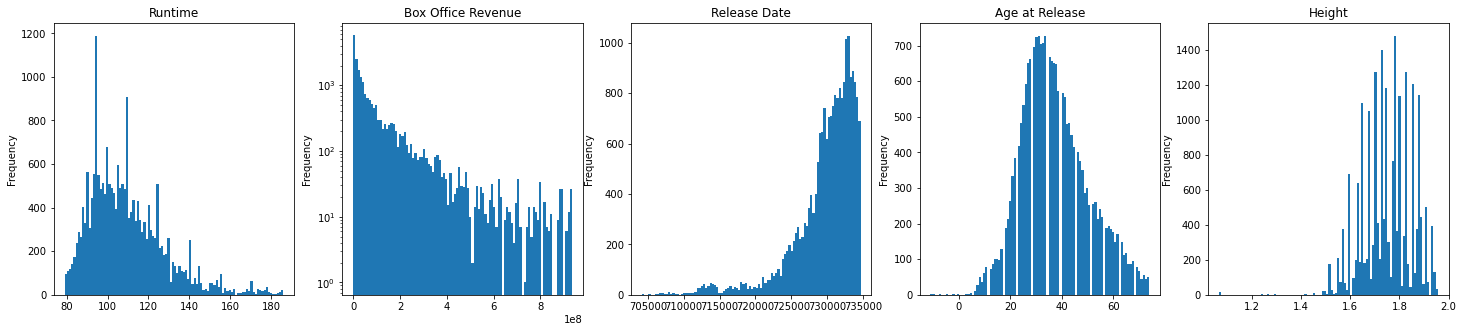

In [75]:
dataset2 = dataset1.copy()

dataset2 = remove_outliers(dataset2, 'runtime', 0.01, 0.99)
dataset2 = remove_outliers(dataset2, 'box_office_revenue', 0, 0.99)
dataset2 = remove_outliers(dataset2, 'release_date', 0, 0.99)
dataset2 = remove_outliers(dataset2, 'a_age_at_release', 0, 0.99)
dataset2 = remove_outliers(dataset2, 'a_height', 0, 0.99)
plot_dataset(dataset2)

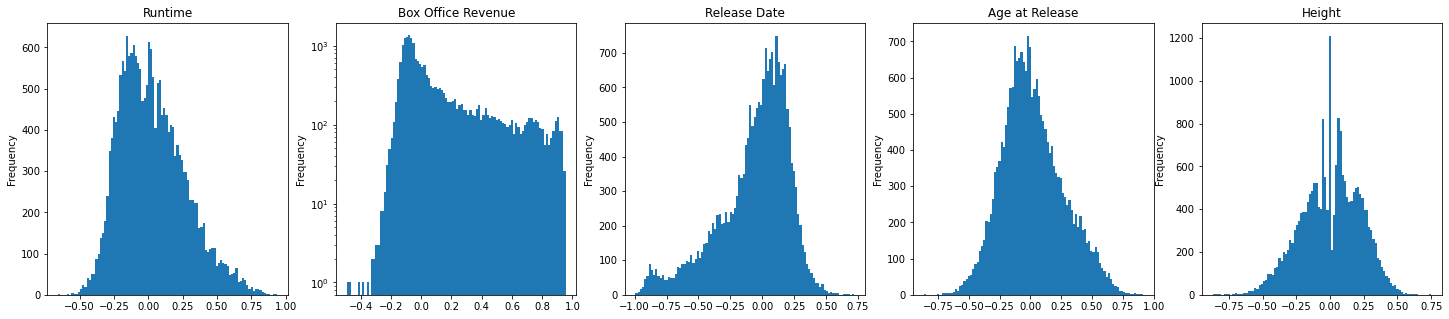

In [93]:
dataset3 = dataset2.copy()

scaler = RobustScaler().fit(dataset3)
dataset3 = pd.DataFrame(scaler.transform(dataset3), columns=dataset3.columns)

normalizer = Normalizer().fit(dataset3)
dataset3 = pd.DataFrame(normalizer.transform(dataset3), columns=dataset3.columns)

plot_dataset(dataset3)

In [86]:
dataset = dataset3.copy()

x, y = dataset.drop(['box_office_revenue'], axis=1), dataset['box_office_revenue']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [87]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Normalization
from keras import Input
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

In [94]:
def plot_loss(history, ax, log=False):
    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    if log:
        ax.set_yscale('log')

    ax.set_title('Model loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['train', 'test'], loc='upper right')

def plot_metric(history, ax, metric, log=False):
    ax.plot(history[metric])
    ax.plot(history[f'val_{metric}'])
    if log:
        ax.set_yscale('log')

    ax.set_title(f'Model {metric}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend(['train', 'test'], loc='best')

def plot_preds_heatmap(y_pred, y_test, ax, displot):
    if displot:
        sns.displot(x=y_pred, y=y_test, kind="kde", fill=True, thresh=0.05, levels=10, ax=ax)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.scatter(x=y_pred, y=y_test, alpha=0.3, s=5, c='red')

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Predicted vs Actual')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

133/133 [==============================] - 0s 1ms/step


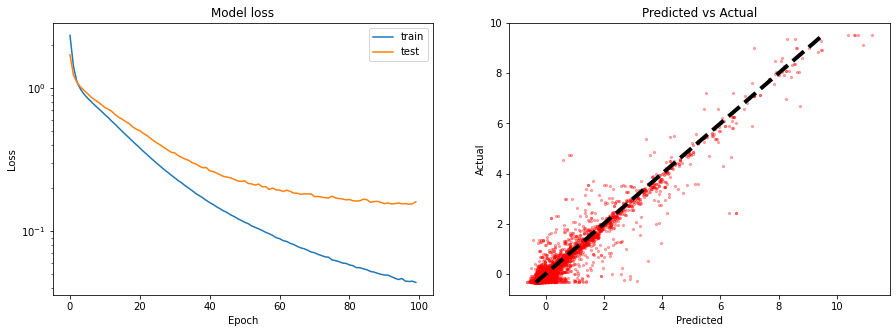

In [97]:
def baseline_model(input_dim, lr):
    """
    """
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))    
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))    
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))

    return model

def plot_model(x_test, y_test, lr, epochs=10, batch_size=10, displot=False, log=False):
    """
    """
    model = baseline_model(x_train.shape[1], lr=lr)
    history = model.fit(x=x_train,
                        y=y_train,
                        validation_data=(x_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0,
                        callbacks=[TqdmCallback(verbose=1)]
                    )

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    plot_loss(history.history, ax[0], log=log)
    
    y_pred = model.predict(x_test)

    pred = y_pred[:, 0]
    test = y_test.to_numpy()

    plot_preds_heatmap(pred, test, ax[1], displot)

lr_schedule = 1e-4

plot_model(x_test, y_test, lr=lr_schedule, epochs=100, batch_size=30, displot=False, log=True)